## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [ ]:
import pandas as pd

In [1]:
import pandas as pd

data = pd.read_csv('data.csv')


In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# место для кода

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [3]:
# место для кода
data = data.dropna(subset=['Age']).reset_index(drop=True)

## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

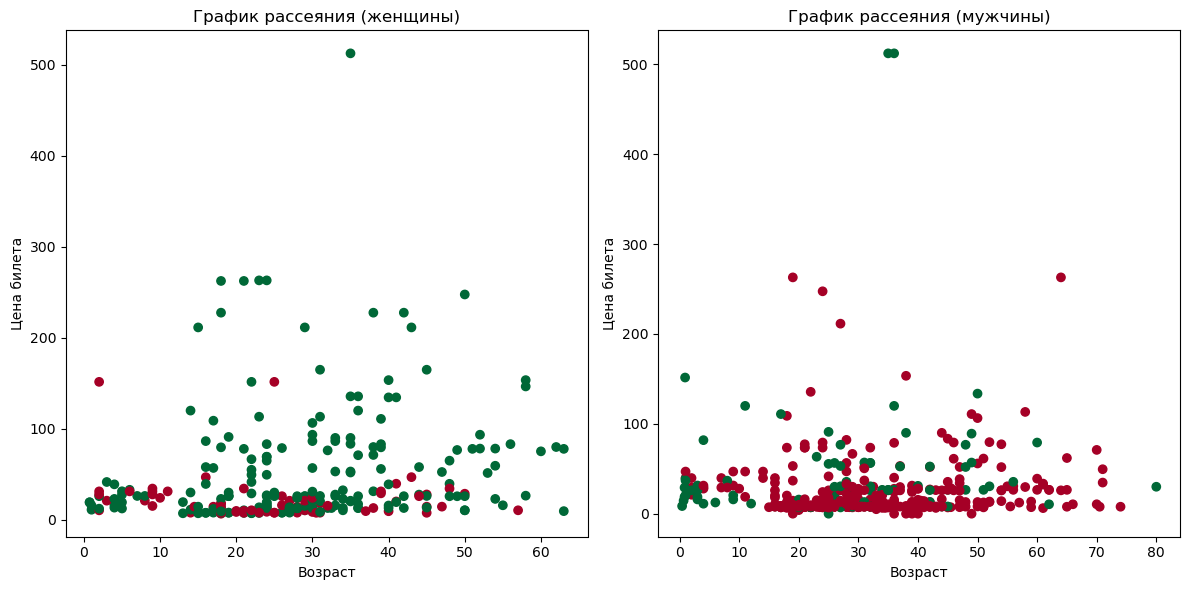

In [6]:
import matplotlib.pyplot as plt

# Создание двух отдельных подграфиков для мужчин и женщин
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# График для женщин
women = data[data['Sex'] == 'female']
scatter1 = ax1.scatter(women['Age'], women['Fare'], c=women['Survived'], cmap='RdYlGn')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Цена билета')
ax1.set_title('График рассеяния (женщины)')

# График для мужчин
men = data[data['Sex'] == 'male']
scatter2 = ax2.scatter(men['Age'], men['Fare'], c=men['Survived'], cmap='RdYlGn')
ax2.set_xlabel('Возраст')
ax2.set_ylabel('Цена билета')
ax2.set_title('График рассеяния (мужчины)')


# Отображение графиков
plt.tight_layout()
plt.show()

In [ ]:
# место для кода

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [7]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [8]:
import numpy as np
import tqdm

In [9]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [10]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data, 5, idx)
print(accuracy/data.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [02:25<00:00,  4.90it/s]

0.726890756302521


Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [11]:
import numpy as np
import tqdm

def calcMargin(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  # LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key=lambda pair: pair[0])
    positive_count = 0
    negative_count = 0
    for i in range(K):
        if dists[i][1] == 1:
            positive_count += 1
        else:
            negative_count += 1
    margin = positive_count - negative_count
    return margin

margins = []
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    margin = calcMargin(data, 5, idx)
    margins.append((idx, margin))

margins = sorted(margins, key=lambda x: x[1])

print("Top 5 Objects with Maximum Margin:")
for i in range(5):
    idx = margins[-(i+1)][0]
    margin = margins[-(i+1)][1]
    print(f"Object {idx}: Margin = {margin}")

print("\nTop 5 Objects with Minimum Margin:")
for i in range(5):
    idx = margins[i][0]
    margin = margins[i][1]
    print(f"Object {idx}: Margin = {margin}")

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [01:53<00:00,  6.31it/s]

Top 5 Objects with Maximum Margin:
Object 711: Margin = 5
Object 664: Margin = 5
Object 662: Margin = 5
Object 609: Margin = 5
Object 606: Margin = 5

Top 5 Objects with Minimum Margin:
Object 0: Margin = -5
Object 4: Margin = -5
Object 10: Margin = -5
Object 11: Margin = -5
Object 14: Margin = -5


In [ ]:
# место для кода

In [ ]:
# место для кода

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [16]:
idx = np.argsort(margins)
idx

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

In [14]:
print('Белые вороны (аномалии)')
data.loc[idx[:5],]

Белые вороны (аномалии)


KeyError: "None of [Index([(1, 0), (1, 0), (1, 0), (1, 0), (1, 0)], dtype='object')] are in the [index]"

In [15]:
print('Эталоны (характерные объекты)')
data.loc[idx[-5:],]

Эталоны (характерные объекты)


KeyError: "None of [Index([(1, 0), (1, 0), (1, 0), (1, 0), (1, 0)], dtype='object')] are in the [index]"